# Pretraining word2vec

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

In [2]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [3]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[-0.2333,  0.8396,  0.3392,  0.0721],
         [-1.1528,  1.6123,  0.0615,  0.2045],
         [ 0.9486,  0.0400,  1.0134, -0.4206]],

        [[-0.1277,  1.8373, -0.9747, -0.3861],
         [ 2.0625,  1.2262,  0.6374,  0.4654],
         [-0.2580, -0.1957,  0.4682, -0.2611]]], grad_fn=<EmbeddingBackward0>)

In [4]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [5]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

In [6]:
class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [7]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [8]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


In [9]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

In [10]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

AttributeError: Can't pickle local object 'load_data_ptb.<locals>.PTBDataset'

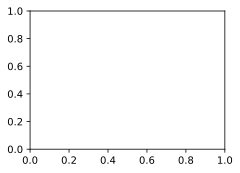

In [11]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)